# 2D Acoustic Wave Equation
---

Consider the 2d acoustic wave equation
$$
\begin{aligned}
&\frac{\partial p}{\partial t} = -c^2(x, z)\rho(x, z)\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial z}\right) + f(x, z, t) \\
&\frac{\partial u}{\partial t} = -\frac{1}{\rho(x, z)}\frac{\partial p}{\partial x} \\
&\frac{\partial v}{\partial t} = -\frac{1}{\rho(x, z)}\frac{\partial p}{\partial z},
\end{aligned}
$$
where $p$ is Pressure, $u, v$ are the $x, z-$components of Particle Velocity, $c, \rho$ are Medium Velocity and Density.

The RHS
$$
f(x, z, t) = R(t)\times 1_{\{x = x_s, z = z_s, t\}} 
$$
is the source term, represented by a Ricker wavelet
$$
R(t) = \left(1-2(\pi f_0(t-t_0))^2\right)\exp\left(-(\pi f_0(t-t_0))^2\right),
$$
where $f_0 = 50$ is the dominant frequency, $t_0 = 0.05$ is time delay.

<p style="color:red"> We can probably use the same technique as the numerical code, i.e., $f(x, z, t) = R(t)\times N(x, z)$, where $N(x, z)$ is a Gaussian centering at $(x_s, z = z_s)$ ? </p>

In this case,
$$
N(x, z) = \exp\left(-\frac{1}{\alpha^2}\left((x-x_s)^2+(z-z_s)^2\right)\right).
$$


---

## Data

- $u$ is unknown
- $v_z$: Velocity in $z-$ direction; the $v$ variable in the equation
- $p$: Pressure
- $\rho(x, z)$: Medium density; We first assume it to be known as
$$
\rho(x, z) = \left\{
\begin{aligned}
&2000, &\quad z\in [100, 150], \\
&1000, &\quad \text{otherwise}.
\end{aligned}
\right.
$$

- All known data are collected in the spatial domain $(x, z) \in [1, 250]\times [1, 250]$, with grid size 5 (which means the spatial grids are {5, 10, ..., 250}. The temporal domain is $t\in [0, 0.25)$, with time step $dt = 0.0025$. This gives 100 time steps as recorded.

- The sources are located at $(x_s, z_s) = \{25, 50, \cdots, 225\} \times \{5\}$.

## Target
- Recover the direct problem $p, u, v$
- Recover the inverse problem $c$

In [1]:
NAME = "0626_1_direct_model_with_source_input"

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("../../")
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")

%load_ext autoreload
%autoreload 2

In [3]:
def generate_model(layers):
	with tf.device("/device:gpu:0"):
		a = tf.Variable(np.ones((len(layers)-2, 1)), dtype = tf.float32)

		def atanh(a, x):
			return K.tanh(a*x)

		model = keras.models.Sequential()
		for i, l in enumerate(layers[:-2]):
			model.add(keras.layers.Dense(layers[i+1], input_shape = (layers[i], ), activation = lambda x: atanh(a[i], x)))
		model.add(keras.layers.Dense(layers[-1]))

		model.a = a
	return model

direct_layers = [4, 32, 32, 32, 32, 3] # (x, z, t, xs) -> (p, u, v)
direct_model = generate_model(direct_layers)

inverse_layers = [2, 32, 32, 1] # (x, z) -> (c)
inverse_model = generate_model(inverse_layers)

In [4]:
@tf.function
def rho(x, z):
	return tf.where(tf.math.logical_and(tf.greater_equal(z, 100), tf.less_equal(z, 150)),
				   2000.0,
				   1000.0)

# source
f_0 = 50.0*np.pi
alpha = 2.0*5 # multiplied by dx
M0 = 1000 # scale p

@tf.function
def R(t, t_s):
	return M0*(1-2*(f_0*(t-t_s))**2)*tf.exp(-(f_0*(t-t_s))**2)

@tf.function
def N(x, z, x_s, z_s):
	return tf.exp(-1.0/(alpha**2) * ((x-x_s)**2 + (z-z_s)**2))

@tf.function
def f(x, z, t, x_s, z_s, t_s):
	return R(t, t_s)*N(x, z, x_s, z_s)

In [6]:
loss_func = keras.losses.MeanSquaredError()
loss_func_r = keras.losses.MeanAbsoluteError()

def get_residue_loss(tape, p, u, v, c, x, z, t, x_s, z_s, t_s):
	dp_dt = tape.gradient(p, t)
	dp_dx = tape.gradient(p, x)
	dp_dz = tape.gradient(p, z)
	du_dt = tape.gradient(u, t)
	du_dx = tape.gradient(u, x)
	dv_dt = tape.gradient(v, t)
	dv_dz = tape.gradient(v, z)
	eq1 = loss_func_r(dp_dt, -tf.square(c)*rho(x, z)*(du_dx+dv_dz)+f(x, z, t, x_s, z_s, t_s))
	eq2 = loss_func_r(du_dt, -1/rho(x, z)*dp_dx)
	eq3 = loss_func_r(dv_dt, -1/rho(x, z)*dp_dz)
	return eq1+eq2+eq3
	
# data: [x_c, z_c, t_c, 
#                x_d, z_d, t_d, p_d, v_d
#                x_i, z_i, t_i, p_i, u_i, v_i
#                x_s, z_s, t_s]
def step(data_sources):
	losses = []
	with tf.GradientTape(persistent = True) as tape:
		tape.watch([x for d in data_sources for x in d])
		for data in data_sources:
			[x_c, z_c, t_c, x_d, z_d, t_d, p_d, v_d, x_i, z_i, t_i, p_i, u_i, v_i, x_s_c, x_s_d, x_s_i, z_s, t_s] = data
			out_c = direct_model(tf.concat([x_c, z_c, t_c, x_s_c], axis = 1))
			c_c = inverse_model(tf.concat([x_c, z_c], axis = 1))
			out_d = direct_model(tf.concat([x_d, z_d, t_d, x_s_d], axis = 1))
			c_d = inverse_model(tf.concat([x_d, z_d], axis = 1))
			out_i = direct_model(tf.concat([x_i, z_i, t_i, x_s_i], axis = 1))
			c_i = inverse_model(tf.concat([x_i, z_i], axis = 1))
			loss_c = get_residue_loss(tape, out_c[:, 0:1], out_c[:, 1:2], out_c[:, 2:3], c_c, x_c, z_c, t_c, x_s_c, z_s, t_s)
			loss_dr = get_residue_loss(tape, out_d[:, 0:1], out_d[:, 1:2], out_d[:, 2:3], c_d, x_d, z_d, t_d, x_s_d, z_s, t_s)
			loss_dv = loss_func(out_d[:, 0:1], p_d) # + loss_func(out_d[:, 2:3], v_d)
			loss_ir = get_residue_loss(tape, out_i[:, 0:1], out_i[:, 1:2], out_i[:, 2:3], c_i, x_i, z_i, t_i, x_s_i, z_s, t_s)
			loss_iv = loss_func(out_i[:, 0:1], p_i) + loss_func(out_i[:, 1:2], u_i) + loss_func(out_i[:, 2:3], v_i)
			losses.append([loss_c, loss_dr, loss_dv, loss_ir, loss_iv])

		loss_c = sum([l[0] for l in losses])
		loss_dr = sum([l[1] for l in losses])
		loss_dv = sum([l[2] for l in losses])
		loss_ir = sum([l[3] for l in losses])
		loss_iv = sum([l[4] for l in losses])
		loss = w_c*loss_c + w_dr*loss_dr + w_dv*loss_dv + w_ir*loss_ir + w_iv*loss_iv
		
	grads = tape.gradient(loss, direct_model.trainable_variables + inverse_model.trainable_variables + [direct_model.a])
	optimizer.apply_gradients(zip(grads, direct_model.trainable_variables + inverse_model.trainable_variables + [direct_model.a]))
	del tape
	return loss, loss_c, loss_dr, loss_dv, loss_ir, loss_iv

# d_s, d_i, d_c, d_d: dataset for each source


# data_sources: [d_1, ..., d_s]; dataset for each source
# d_j: [d_j_i, d_j_c, d_j_d, d_j_s]
# d_j_i: [x_i, z_i, t_i, p_i, u_i, v_i]
# d_j_c: [x_c, z_c, t_c]
# d_j_d: [x_d, z_d, t_d, p_d, v_d]
# d_j_s: [x_s, z_s, t_s]
def train(data_sources, epochs, batch_proportion = 0.1, print_every = 100, save_every = 10000, save_path = None):
	shuffled = lambda dataset: [tf.data.Dataset.from_tensor_slices(tuple(d)).shuffle(buffer_size = max(d[0].shape[0], 1), \
                                                        reshuffle_each_iteration = True).batch(max(int(batch_proportion*d[0].shape[0]), 1)) \
                                        for d in dataset]
	data_s = shuffled([d for d_s in data_sources for d in d_s[:-1]])
	source_locations = [d[-1] for d in data_sources]
	for epoch in range(1, epochs+1):
		losses = np.zeros((6,))
		for d in zip(*data_s): # d: [d_1_i, d_1_c, d_1_d, d_2_i, ...]
			data_sources = [list(d[i*3+1])+list(d[i*3+2])+list(d[i*3])+source_locations[i] for i in range(n_sources)]
			loss = step(data_sources)
			losses += np.array(loss)
		losses *= batch_proportion
		
		if epoch % print_every == 0:
			print("{}, Epoch: {}, Loss: {:.4e}, loss_c: {:.4e}, \
					  loss_dr: {:.4e}, loss_dv: {:.4e}, loss_ir: {:.4e}, loss_iv: {:.4e}".format(get_time(), epoch, *list(losses)))

		if epoch % save_every == 0:
			
			direct_model.save("models/{}/{}/direct_model".format(NAME, save_path))
			inverse_model.save("models/{}/{}/inverse_model".format(NAME, save_path))

In [7]:
from scipy.io import loadmat

x_s = np.linspace(25.0, 225.0, 9)
z_s = 5.0
t_s = 0.05
n_sources = len(x_s)

domain = [0, 250]
T_max = 0.25
dx = 5
dt = 0.0025

x_d = np.linspace(5.0, 250.0, 50)
z_d = [5.0]
t_d = np.linspace(0.0, 0.2475, 100)

n_c = 1000
x_c = transform(np.random.random((n_c, 1)), *domain)
z_c = transform(np.random.random((n_c, 1)), *domain)
t_c = transform(np.random.random((n_c, 1)), 0, T_max)

n_s = 100
x_c_source = np.vstack([transform(np.random.random((n_s, 1)), xi-5, xi+5) for xi in x_s])
z_c_source = np.vstack([transform(np.random.random((n_s, 1)), z_s-5, z_s+5) for i in x_s])
t_c_source = np.vstack([transform(np.random.random((n_s, 1)), t_s-0.05, t_s+0.05) for i in x_s])

x_c = np.vstack([x_c, x_c_source])
z_c = np.vstack([z_c, z_c_source])
t_c = np.vstack([t_c, t_c_source])

n_i = 2000
x_i = transform(np.random.random((n_i, 1)), *domain)
z_i = transform(np.random.random((n_i, 1)), *domain)
t_i = np.zeros_like(x_i)
p_i = np.zeros_like(x_i)
u_i = np.zeros_like(x_i)
v_i = np.zeros_like(x_i)

# txz_c = tensor_grid([t_c, x_c, z_c])
txz_d = tensor_grid([t_d, x_d, z_d])

map_to_tf_float32 = lambda x: list(map(lambda y: tf.constant(y, dtype = tf.float32), x))

data_sources = []
for x in x_s:
	p = loadmat("data/sr_p_{}.mat".format(int(x/5)))["sr"].reshape((-1, 1))*1000
	v = loadmat("data/sr_vz_{}.mat".format(int(x/5)))["sr"].reshape((-1, 1))
	d_i = map_to_tf_float32([x_i, z_i, t_i, p_i, u_i, v_i])
# 	d_c = map_to_tf_float32([txz_c[:, 1:2], txz_c[:, 2:3], txz_c[:, 0:1]])
	d_c = map_to_tf_float32([x_c, z_c, t_c])
	d_d = map_to_tf_float32([txz_d[:, 1:2], txz_d[:, 2:3], txz_d[:, 0:1], p, v])
	d_s = map_to_tf_float32([x*np.ones_like(x_c), x*np.ones_like(txz_d[:, 1:2]), x*np.ones_like(x_i), z_s, t_s])
	data_sources.append([d_i, d_c, d_d, d_s])

In [10]:
i = 1
optimizer = keras.optimizers.Adam(lr = 1e-3)
w_c, w_dr, w_dv, w_ir, w_iv = 1.0, 1.0, 100.0, 1.0, 100.0
train(data_sources, 10000, batch_proportion = 1.0, print_every = 10, save_every = 10000, save_path = "{}_adam".format(i))

2020/06/28, 01:32:05, Epoch: 10, Loss: 9.2373e+01, loss_c: 5.1613e+01, 					  loss_dr: 2.7993e+01, loss_dv: 7.3696e-02, loss_ir: 5.6815e-02, loss_iv: 5.3401e-02
2020/06/28, 01:32:38, Epoch: 20, Loss: 8.6849e+01, loss_c: 5.1584e+01, 					  loss_dr: 2.7943e+01, loss_dv: 5.1775e-02, loss_ir: 4.2721e-02, loss_iv: 2.1018e-02
2020/06/28, 01:33:12, Epoch: 30, Loss: 8.5320e+01, loss_c: 5.1574e+01, 					  loss_dr: 2.7931e+01, loss_dv: 4.6296e-02, loss_ir: 3.2849e-02, loss_iv: 1.1527e-02
2020/06/28, 01:33:45, Epoch: 40, Loss: 8.4736e+01, loss_c: 5.1571e+01, 					  loss_dr: 2.7928e+01, loss_dv: 4.5303e-02, loss_ir: 2.9671e-02, loss_iv: 6.7744e-03
2020/06/28, 01:34:19, Epoch: 50, Loss: 8.4430e+01, loss_c: 5.1567e+01, 					  loss_dr: 2.7925e+01, loss_dv: 4.4894e-02, loss_ir: 2.6977e-02, loss_iv: 4.2124e-03
2020/06/28, 01:34:54, Epoch: 60, Loss: 8.4329e+01, loss_c: 5.1565e+01, 					  loss_dr: 2.7921e+01, loss_dv: 4.4908e-02, loss_ir: 2.4594e-02, loss_iv: 3.2792e-03
2020/06/28, 01:35:26, Epoch: 70, L

KeyboardInterrupt: 

In [ ]:
i = 2
optimizer = keras.optimizers.Adam(lr = 1e-3)
w_c, w_dr, w_dv, w_ir, w_iv = 1.0, 1.0, 1e6, 1.0, 100.0
train(data_sources, 100000, batch_proportion = 1.0, print_every = 100, save_every = 10000, save_path = "{}_adam".format(i))

In [ ]:
i = 2
optimizer = keras.optimizers.Adam(lr = 1e-3)
w_c, w_dr, w_dv, w_ir, w_iv = 1.0, 1.0, 100.0, 1.0, 100.0
train(data_sources, 10000, batch_proportion = 1.0, print_every = 1, save_every = 10000, save_path = "{}_adam".format(i))

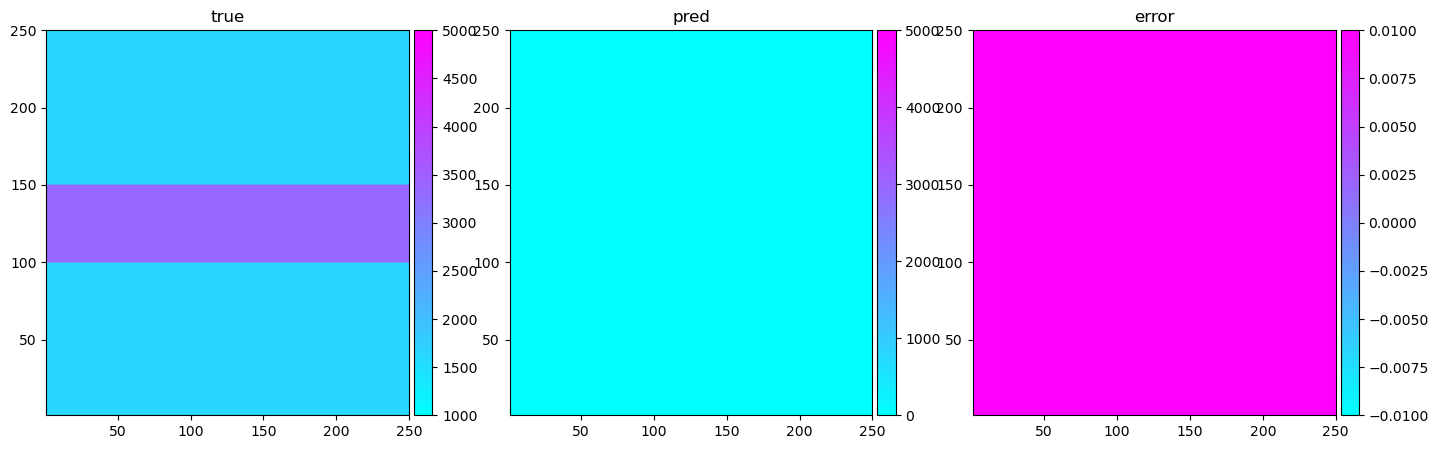

In [19]:
x_test = np.linspace(1.0, 250.0, 250)
z_test = np.linspace(1.0, 250.0, 499)
xz_test = tensor_grid([z_test, x_test])
xz_test[:, [0, 1]] = xz_test[:, [1, 0]]

c_pred = inverse_model(tf.constant(xz_test, dtype = tf.float32))
def c_func(x, z):
	return np.piecewise(z, [z > 150, (z >= 100) & (z <= 150), z < 100], [1500, 3500, 1500])
c_true = c_func(xz_test[:, 0:1], xz_test[:, 1:2])

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = cool
norm = Normalize(vmin=1000, vmax=5000)

X, Z = np.meshgrid(x_test, z_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Z, c_true.reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=0, vmax=5000)
im1 = ax[1].contourf(X, Z, c_pred.numpy().reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, Z, c_true.reshape((len(z_test), len(x_test)))-c_pred.numpy().reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
ax[2].set_title("error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

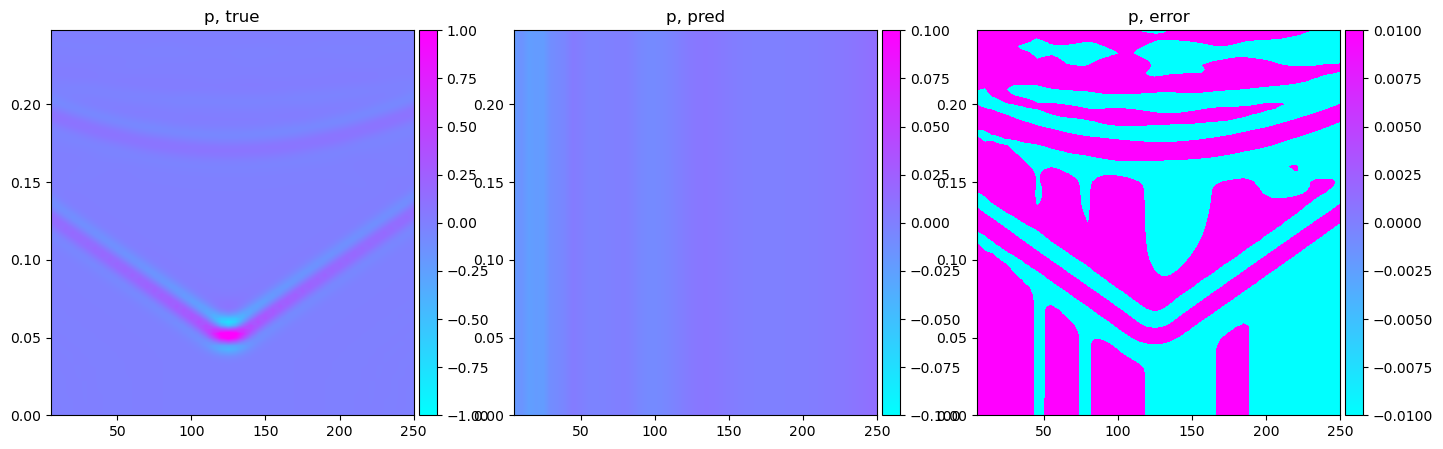

In [20]:
i = 0
p = loadmat("data/sr_p_{}.mat".format(int(x_s[i])))["sr"]*1000
v = loadmat("data/sr_vz_{}.mat".format(int(x_s[i])))["sr"]

x_test = np.linspace(5.0, 250.0, 50)
# z_test = np.linspace(1.0, 250.0, 250)
z_test = [0]
t_test = np.linspace(0.0, 0.2475, 100)
xzt_test = tensor_grid([t_test, x_test, z_test])
xzt_test[:, [0, 1, 2]] = xzt_test[:, [1, 2, 0]]

xzts = np.hstack([xzt_test, x_s[i]*np.ones_like(xzt_test[:, 0:1])])
out = direct_model(tf.constant(xzts, dtype = tf.float32))

cmap = cool
norm = Normalize(vmin=-1, vmax=1)

X, T = np.meshgrid(x_test, t_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, T, p, cmap = cmap, norm = norm, levels = 1000)
ax[0].set_title("p, true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = Normalize(vmin=-0.1, vmax=0.1)
im1 = ax[1].contourf(X, T, out[:, 0:1].numpy().reshape((len(t_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[1].set_title("p, pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, T, p-out[:, 0:1].numpy().reshape((len(t_test), len(x_test))), cmap = cmap, norm = norm)
ax[2].set_title("p, error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

In [ ]:
X.shape

In [ ]:
p.shape